---
title: "Analysis of the Football Database"
format:
  html:
    toc: true
    code-fold: true
    code-summary: "Show the code"
    number-depth: 4
    number-sections: true
---

## Introduction

This is the analysis of the [football data set from Kaggle](https://www.kaggle.com/datasets/prajitdatta/ultimate-25k-matches-football-database-european). The aims of this project are to explore the data set and eventually gain insights on potential betting strategies by building models that predict match outcomes.

### Imports and Options

#### Imports

In [1]:
%reload_ext autoreload
%autoreload 1
# Data handling
import duckdb
import pandas as pd
import numpy as np

# Display
from IPython.display import Markdown, display
from tabulate import tabulate

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from mplsoccer import Pitch

# Statistics
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from lmfit import Minimizer, Parameters

# Custom
import functions.display_functions as disf
import functions.data_format_functions as dff
from functions.project_functions_classes import Team, MatchPlayers
from functions.project_functions_classes import outcome_guess_prob_dif
from functions.project_functions_classes import outcome_guess_prob_win
from functions.project_functions_classes import classifier_train_prob_win
from functions.project_functions_classes import classifier_train_prob_dif
%aimport functions.display_functions
%aimport functions.project_functions_classes
%aimport functions.data_format_functions

#### Options

##### Pandas and figure options:

In [2]:
pd.set_option("mode.chained_assignment", None)
sns.set()
base_fig_width = 8
base_fig_height = 4.5

##### DuckDB connection and options:

In [3]:
con = duckdb.connect()
con.execute(f"INSTALL sqlite")
con.execute(f"LOAD sqlite")
con.execute(f"SET GLOBAL sqlite_all_varchar=true")
con.execute(f"CALL sqlite_attach('data/database.sqlite')")


##### Fetching table and column names:

In [4]:
tables = con.query(
    f"""--sql
SELECT table_name as 'Table Name',
    COUNT(column_name) AS 'Column Count'
FROM information_schema.columns
GROUP BY table_name
"""
).to_df()

table_columns = con.query(
    f"""--sql
SELECT table_name,
    GROUP_CONCAT(column_name) AS column_names
FROM information_schema.columns
GROUP BY table_name"""
).to_df()
tables["column_names"] = table_columns["column_names"].apply(lambda x: x.split(","))


##### Significance:

In [5]:
alpha = 0.95
significance = 1 - alpha

## Exploratory data analysis

The goal of this section is to familiarize with the data set. Some statistical inference is presented here, but the feature selection for ML models are presented in a separate section and mostly relies on their predictive power.

### Match

The data set includes data on more than 25 thousand matches. Outcomes, betting odds, players, teams, and their starting lineup positions are given. This section explores match related portion of the data set.

##### Preparing Match data:

In [6]:
match_cols = tables.loc[tables["Table Name"] == "Match", "column_names"].to_list()[0]
match_cols_to_remove = ["league_id", "stage", "match_api_id", "cross"]
match_cols = [col for col in match_cols if col not in match_cols_to_remove]
match_raw = con.query(
    f"""--sql
          SELECT {', '.join(match_cols)} FROM Match
          """
).to_df()
match_raw.set_index("id", inplace=True)

#### What in what countries and leagues were the matches played in? By which teams and in which leagues were the most goals scored in?

<iframe width="850" height="638" src="https://lookerstudio.google.com/embed/reporting/7fdf4aab-2c53-454b-8e7e-adc93591e2dd/page/fsdXD" frameborder="0" style="border:0" allowfullscreen></iframe>

The Matches were played in 11 different leagues across 11 different European countries. The most goals per match were scored in Netherlands Eredivisie, while the team that scored the most goals per match was FC Barcelona.

#### Whats the number of matches distribution across the timeline and seasons?

##### Preparing the season and date data:

In [7]:
match_raw["date"] = pd.to_datetime(match_raw["date"])
match_date_count = match_raw.resample("D", on="date").count().cumsum()

seasons = match_raw.groupby("season").agg(
    start=("date", "min"), end=("date", "max"), count=("season", "count")
)
seasons["length"] = seasons["end"] - seasons["start"]

##### Plot:

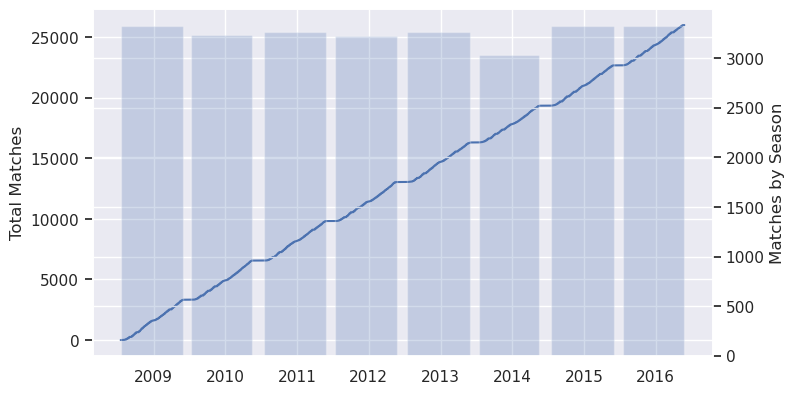

In [8]:
# | label: fig-match_count
# | fig-cap: The cumulative sum of total matches played are represented by the blue line, the bars in the background indicate the number of matches played that season and its time span.
fig_match_count_date, ax_match_count_date = plt.subplots(
    figsize=(base_fig_width, base_fig_height)
)

ax_match_count_date.plot(match_date_count.index, match_date_count["country_id"])
ax_match_count_date_season = ax_match_count_date.twinx()
ax_match_count_date_season.bar(
    x=seasons["start"],
    height=seasons["count"],
    width=seasons["length"],
    align="edge",
    alpha=0.25,
)
ax_match_count_date.set_ylabel("Total Matches")
ax_match_count_date_season.set_ylabel("Matches by Season")

plt.show()


Matches are in the data set were played from 2008 to 2016 in 8 seasons.

#### What is the distribution of goal difference between home and away teams?

##### Calculating the goal difference for each mach:

In [9]:
match_raw[["home_team_goal", "away_team_goal"]] = match_raw[
    ["home_team_goal", "away_team_goal"]
].astype(int)
match_raw["outcome"] = match_raw["home_team_goal"] - match_raw["away_team_goal"]
match_outcomes = match_raw["outcome"].value_counts().to_frame("count")
match_outcomes.reset_index(names=["value"], inplace=True)
match_outcomes["outcome"] = match_outcomes["value"].apply(
    lambda x: "Home Win" if x > 0 else ("Home Loss" if x < 0 else "Tie")
)
match_outcomes["color"] = match_outcomes["value"].apply(
    lambda x: sns.color_palette()[0]
    if x > 0
    else (sns.color_palette()[3] if x < 0 else sns.color_palette()[4])
)


##### Plot:

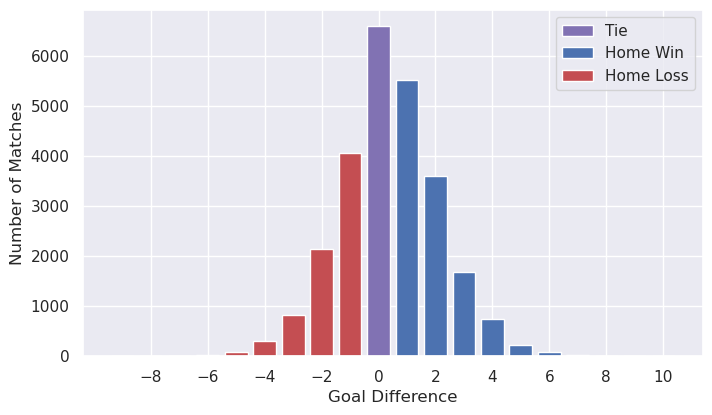

In [10]:
# | label: fig-match_outcomes
# | fig-cap: The number of matches that ended with a specific goal difference.
fig_match_outcomes, ax_match_outcomes = plt.subplots(
    figsize=(base_fig_width, base_fig_height)
)
ax_match_outcomes.bar(
    match_outcomes["value"],
    match_outcomes["count"],
    label=match_outcomes["outcome"],
    color=match_outcomes["color"],
    align="center",
)
handles, labels = ax_match_outcomes.get_legend_handles_labels()
ax_match_outcomes.legend(handles[:3], labels[:3])
ax_match_outcomes.set(xticks=np.arange(start=-8, stop=12, step=2))
ax_match_outcomes.set_ylabel("Number of Matches")
ax_match_outcomes.set_xlabel("Goal Difference")
plt.show()


Visual inspection of the match outcome data suggests that there might be a home advantage. Another important observation is that a large portion of matches end in ties.

#### Is there a home advantage?

##### Chi square test of non-tie matches with the null hypothesis being that there is an equal amount of home wins and away wins:

In [11]:
total_home_wins = match_outcomes.loc[
    match_outcomes["outcome"] == "Home Win", "count"
].sum()
total_away_wins = match_outcomes.loc[
    match_outcomes["outcome"] == "Home Loss", "count"
].sum()
home_advantage_result = stats.chisquare([total_home_wins, total_away_wins])

##### Results:

In [12]:
Markdown(
    f"""
Based on a chi-square test with a confidence level of 95%, the p-value of {home_advantage_result.pvalue:.2e}
strongly suggests that there is a significant home advantage.
{total_home_wins} of all non-tie wins were by the home team,
while only {total_away_wins} matches were won by away teams.
"""
)


Based on a chi-square test with a confidence level of 95%, the p-value of 2.82e-224
strongly suggests that there is a significant home advantage.
11917 of all non-tie wins were by the home team,
while only 7466 matches were won by away teams.


#### What are the different player combinations used?

The data set includes starting lineup positions on the field.

##### Preparing player position combination columns:

In [13]:
# Getting lists of position column names
home_x_cols = [x for x in match_raw.columns.to_list() if "home_player_X" in x]
home_y_cols = [x for x in match_raw.columns.to_list() if "home_player_Y" in x]
away_x_cols = [x for x in match_raw.columns.to_list() if "away_player_X" in x]
away_y_cols = [x for x in match_raw.columns.to_list() if "away_player_Y" in x]

# Changing  the data type to numeric
match_raw[home_x_cols + home_y_cols + away_x_cols + away_y_cols] = match_raw[
    home_x_cols + home_y_cols + away_x_cols + away_y_cols
].apply(pd.to_numeric)

# Putting the home player coordinates into frozensets of (x,y) tuples
match_raw["combinations_home"] = match_raw.apply(
    lambda row: frozenset([(x, y) for x, y in zip(row[home_x_cols], row[home_y_cols])]),
    axis=1,
)

# Changing any values that contain at least a single NaN value to Nan
match_raw["combinations_home"] = match_raw["combinations_home"].apply(
    lambda x: np.nan if any(np.isnan(y) for tup in x for y in tup) else x
)

# Removing frozensets with less than 11 player coordinates
match_raw["combinations_home"] = match_raw["combinations_home"].apply(
    lambda x: x if type(x) == frozenset and len(x) == 11 else np.nan
)

# Putting the away player coordinates into frozensets of (x,y) tuples
match_raw["combinations_away"] = match_raw.apply(
    lambda row: frozenset([(x, y) for x, y in zip(row[away_x_cols], row[away_y_cols])]),
    axis=1,
)

# Removing frozensets with less than 11 player coordinates
match_raw["combinations_away"] = match_raw["combinations_away"].apply(
    lambda x: np.nan if any(np.isnan(y) for tup in x for y in tup) else x
)

# Putting the away player coordinates into frozensets of (x,y) tuples
match_raw["combinations_away"] = match_raw["combinations_away"].apply(
    lambda x: x if type(x) == frozenset and len(x) == 11 else np.nan
)

##### Number of different 11 player combinations:

In [14]:
unique_combos = (
    pd.concat([match_raw["combinations_home"], match_raw["combinations_away"]])
    .value_counts()
    .to_frame(name="count")
    .reset_index(names=["combo"])
)
len(unique_combos)

37

##### Combination distribution on the pitch:

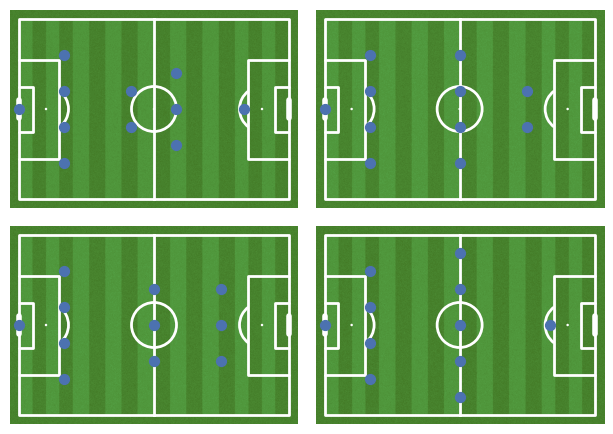

In [15]:
# | label: fig-pitch
# | fig-cap: The four most popular starting lineup position combinations.

# Correcting the position of the goal keeper
unique_combos["scaled_combo"] = unique_combos["combo"].apply(
    lambda x: frozenset((5, 1) if t == (1, 1) else t for t in x)
)

# Scaling to the pitch plot
pitch_y_offset = 4 - dff.scale_num(1, 1, 11, -4, 80)
unique_combos["scaled_combo"] = unique_combos["scaled_combo"].apply(
    lambda x: frozenset(
        (
            dff.scale_num(t[0], 1, 11, 0, 80) + pitch_y_offset,
            dff.scale_num(t[1], 1, 11, 0, 100),
        )
        for t in x
    )
)

pitch = Pitch(
    pitch_color="grass",
    line_color="white",
    stripe=True,
)

fig_pitch, ax_pitch = pitch.draw(
    nrows=2, ncols=2, figsize=(base_fig_width, base_fig_height)
)
ax_pitch = ax_pitch.flatten()

for i, combo in enumerate(unique_combos[:4].iterrows()):
    for pos in combo[1]["scaled_combo"]:
        ax_pitch[i].scatter(
            pos[1],
            pos[0],
            s=50,
            color=sns.color_palette("deep")[0],
        )
plt.tight_layout(w_pad=-6)
plt.show()

### Player attributes

The dataset included a variety of numerical and categorical player attributes, this section presents this portion of the data.

#### What is the player rating and potential distribution?

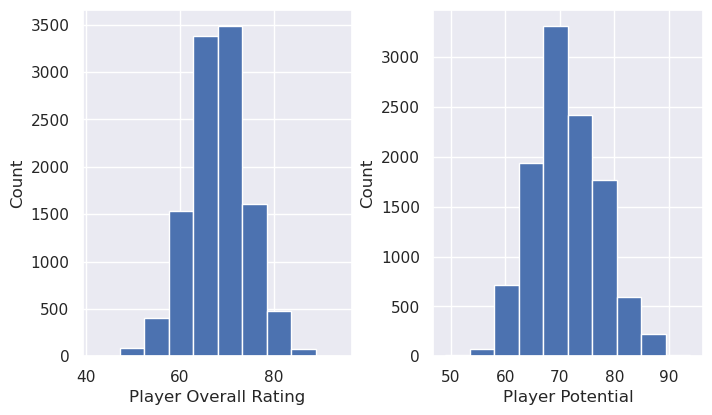

In [16]:
# | label: fig-player_rating_hist
# | fig-cap: The distribution of player overall rating and potential. The latest stats of each player is included in this figure.

# Fetching player attributes with the latest date.
rating_potential = con.query(
    """--sql
SELECT overall_rating,
    potential
FROM Player_Attributes p
    JOIN(
        SELECT player_api_id,
            MAX(date) AS max_date
        FROM Player_attributes
        GROUP BY player_api_id
    ) sub ON p.player_api_id = sub.player_api_id
    AND p.date = sub.max_date """
).to_df()
rating_potential.dropna(inplace=True)
rating_potential = rating_potential.astype(int)

# Plot
fig_player_rating_hist, (
    ax_player_rating_hist,
    ax_player_potential_hist,
) = plt.subplots(1, 2, figsize=(base_fig_width, base_fig_height))

rating_potential.hist("potential", ax=ax_player_potential_hist)
rating_potential.hist("overall_rating", ax=ax_player_rating_hist)
disf.axis_titles(ax_player_potential_hist, xtitle="Player Potential", ytitle="Count")
disf.axis_titles(ax_player_rating_hist, xtitle="Player Overall Rating", ytitle="Count")
plt.show()

#### Whats is the foot preference distribution?

In [17]:
con.query(
    f"""--sql
SELECT 
    COUNT(*) AS total,
    SUM(CASE WHEN preferred_foot = 'right' THEN 1 ELSE 0 END) AS right_count,
    SUM(CASE WHEN preferred_foot = 'left' THEN 1 ELSE 0 END) AS left_count
FROM Player_Attributes p
    JOIN(
        SELECT player_api_id,
            MAX(date) AS max_date
        FROM Player_attributes
        GROUP BY player_api_id
    ) sub ON p.player_api_id = sub.player_api_id
    AND p.date = sub.max_date"""
).to_df().astype(int).rename(
    columns={
        "total": "Total",
        "right_count": "Right footed players",
        "left_count": "Left footed players",
    }
)

,Total,Right footed players,Left footed players
0,11064,8373,2687


#### Do right and left footed players have a different overall rating?

##### Fetching the data:

In [18]:
player_f_rating = con.query(
    f"""--sql
SELECT  CAST(overall_rating as INT) AS 'Overall Rating', preferred_foot
FROM Player_Attributes p
    JOIN(
        SELECT player_api_id,
            MAX(date) AS max_date
        FROM Player_attributes
        GROUP BY player_api_id
    ) sub ON p.player_api_id = sub.player_api_id
    AND p.date = sub.max_date"""
).to_df()

##### T-test:

In [19]:
player_f_rating_levresults = stats.levene(
    player_f_rating.loc[player_f_rating["preferred_foot"] == "right", "Overall Rating"],
    player_f_rating.loc[player_f_rating["preferred_foot"] == "left", "Overall Rating"],
)

player_f_rating_tresults = stats.ttest_ind(
    player_f_rating.loc[player_f_rating["preferred_foot"] == "right", "Overall Rating"],
    player_f_rating.loc[player_f_rating["preferred_foot"] == "left", "Overall Rating"],
    equal_var=player_f_rating_levresults.pvalue > significance,
)
Markdown(
    f"""t-statistic: {round(player_f_rating_tresults.statistic,2)}<br>
         p-val: {round(player_f_rating_tresults.pvalue,2)}<br>
         There {'is a' if player_f_rating_tresults.pvalue < significance else 'is no'} 
         significant difference in overall rating between right and left footed players
         """
)


t-statistic: -0.54<br>
         p-val: 0.59<br>
         There is no 
         significant difference in overall rating between right and left footed players
         

#### What is the distribution of goal keeper attributes?

##### Getting the histogram data for goal keeper diving ability:

In [20]:
goaly_hist_df = (
    con.query(
        f"""--sql
WITH bin_stats AS (
    SELECT (
            (
                MAX(CAST(gk_diving AS INT)) - MIN(CAST(gk_diving AS INT))
            ) / 10
        ) AS bin_size
    FROM Player_Attributes p
        JOIN(
            SELECT player_api_id,
                MAX(date) AS max_date
            FROM Player_attributes
            GROUP BY player_api_id
        ) sub ON p.player_api_id = sub.player_api_id
        AND p.date = sub.max_date
)
SELECT FLOOR(
        CAST(gk_diving AS INT) / (
            SELECT bin_size
            FROM bin_stats
        )
    ) * (
        SELECT bin_size
        FROM bin_stats
    ) AS bin,
    COUNT(*) AS count
FROM Player_Attributes p
    JOIN(
        SELECT player_api_id,
            MAX(date) AS max_date
        FROM Player_attributes
        GROUP BY player_api_id
    ) sub ON p.player_api_id = sub.player_api_id
    AND p.date = sub.max_date
GROUP BY bin
ORDER BY bin;
    """
    )
    .to_df()
    .astype(int, errors="ignore")
)

##### Plotting the frequencies:

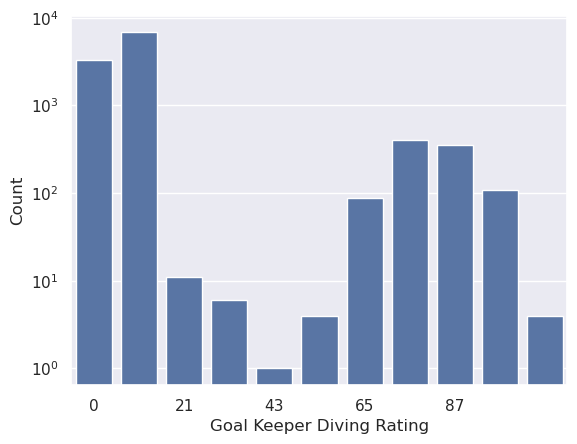

In [21]:
# | label: fig-goaly_stats
# | fig-cap: The distribution of "Goal keeper diving rating across all players in the data set. The latest entry for each player is taken."

fig_goaly_stats, ax_goaly_stats = plt.subplots()
sns.barplot(
    goaly_hist_df, x="bin", y="count", ax=ax_goaly_stats, color=sns.color_palette()[0]
)
ax_goaly_stats.set_xticks(np.arange(0, 10, step=2))
ax_goaly_stats.set_xticklabels(
    np.linspace(goaly_hist_df["bin"].min(), goaly_hist_df["bin"].max(), num=5).astype(
        int
    )
)
ax_goaly_stats.set_yscale("log")
disf.axis_titles(ax=ax_goaly_stats, ytitle="Count", xtitle="Goal Keeper Diving Rating")
plt.show()

The distribution of goalkeeper attributes indicate that there is a split between goalkeepers and regular players.

#### Is there a linear correlation between player overall ratings and their other attributes?

##### Importing all player attributes:

In [22]:
player_attr_raw = con.query(
    f"""--sql
SELECT * FROM Player_Attributes
"""
).to_df()
player_attr_numeric = [
    "overall_rating",
    "potential",
    "crossing",
    "finishing",
    "heading_accuracy",
    "short_passing",
    "volleys",
    "dribbling",
    "curve",
    "free_kick_accuracy",
    "long_passing",
    "ball_control",
    "acceleration",
    "sprint_speed",
    "agility",
    "reactions",
    "balance",
    "shot_power",
    "jumping",
    "stamina",
    "strength",
    "long_shots",
    "aggression",
    "interceptions",
    "positioning",
    "vision",
    "penalties",
    "marking",
    "standing_tackle",
    "sliding_tackle",
    "gk_diving",
    "gk_handling",
    "gk_kicking",
    "gk_positioning",
    "gk_reflexes",
]
player_attr_raw[player_attr_numeric] = player_attr_raw[player_attr_numeric].apply(
    pd.to_numeric
)
player_attr_raw["date"] = pd.to_datetime(player_attr_raw["date"])

##### Calculating and displaying the correlations:

In [23]:
# | label: tbl-rating_att_corr
# | tbl-cap: Pearson's r of overall rating versus other player attributes calculated for all players and goalkeepers separately. The goalkeepers here are defined as having goal keeper diving attribute higher than 50.

player_att_corrs = (
    player_attr_raw[player_attr_numeric]
    .corr()["overall_rating"]
    .to_frame()
    .join(
        player_attr_raw[player_attr_numeric]
        .loc[player_attr_raw[player_attr_numeric]["gk_diving"] > 50]
        .corr()["overall_rating"]
        .to_frame(),
        rsuffix="_goal_keeper",
    )
)


player_att_corrs.style.background_gradient("coolwarm").format("{:.2f}")

,overall_rating,overall_rating_goal_keeper
overall_rating,1.00,1.00
potential,0.77,0.80
crossing,0.36,-0.03
finishing,0.33,-0.03
heading_accuracy,0.31,-0.04
short_passing,0.46,0.12
volleys,0.36,-0.01
dribbling,0.35,-0.03
curve,0.36,-0.03
free_kick_accuracy,0.35,0.01


As seen in table @tbl-rating_att_corr, For all players there are moderate linear correlations between player overall ratings and all attributes except those related to goal keeping. It is the opposite for dedicated goalkeepers.

#### Whats the distribution of attacking and defensive work?

##### Fetching the data:

In [24]:
att_def_df = con.query(
    f"""--sql
SELECT attacking_work_rate, defensive_work_rate
FROM Player_Attributes p
    JOIN(
        SELECT player_api_id,
            MAX(date) AS max_date
        FROM Player_attributes
        GROUP BY player_api_id
    ) sub ON p.player_api_id = sub.player_api_id
    AND p.date = sub.max_date"""
).to_df()

##### Plot:

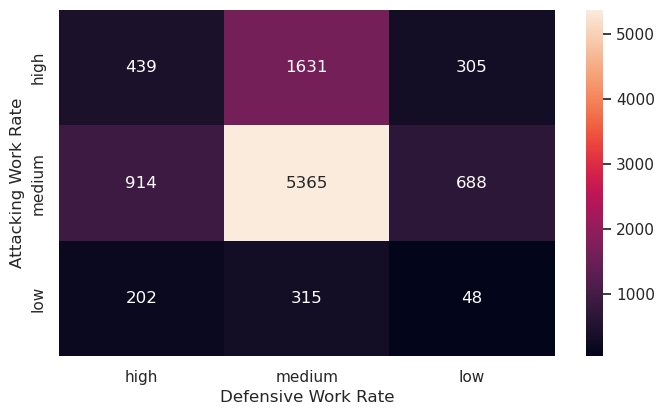

In [25]:
# | label: fig-att_def
# | fig-cap: A heatmap of defensive and attacking work rate of all players. The latest entries for each player were taken.

fig_att_def, ax_att_def = plt.subplots(figsize=(base_fig_width, base_fig_height))
sns.heatmap(
    pd.crosstab(att_def_df["attacking_work_rate"], att_def_df["defensive_work_rate"])[
        ["high", "medium", "low"]
    ].loc[["high", "medium", "low"]],
    annot=True,
    fmt=".0f",
    ax=ax_att_def,
)
disf.axis_titles(
    ax=ax_att_def, xtitle="Defensive Work Rate", ytitle="Attacking Work Rate"
)

The majority of players have both medium attacking and defensive work rates.

### Team Attributes

This section explores the attributes of individual teams that were given in the data set.

##### Fetching the team attributes:

In [26]:
team_attr_raw = con.query(
    f"""--sql
SELECT *
FROM Team_Attributes
"""
).to_df()

#### What is the distribution of Team attributes?

##### Making a list of numeric attributes and fixing data types:

In [27]:
team_numeric_cols = [
    "buildUpPlaySpeed",
    "buildUpPlayDribbling",
    "buildUpPlayPassing",
    "chanceCreationPassing",
    "chanceCreationCrossing",
    "chanceCreationShooting",
    "defencePressure",
    "defenceAggression",
    "defenceTeamWidth",
]
team_categoric_cols = [col + "Class" for col in team_numeric_cols]
team_attr_raw[team_numeric_cols] = team_attr_raw[team_numeric_cols].apply(
    pd.to_numeric, errors="coerce"
)
team_attr_raw["date"] = pd.to_datetime(team_attr_raw["date"])
team_attr_raw.set_index("id", inplace=True)

latest_team_attr = team_attr_raw.loc[team_attr_raw.groupby("team_api_id").date.idxmax()]

##### Plotting numeric attributes and their categories:

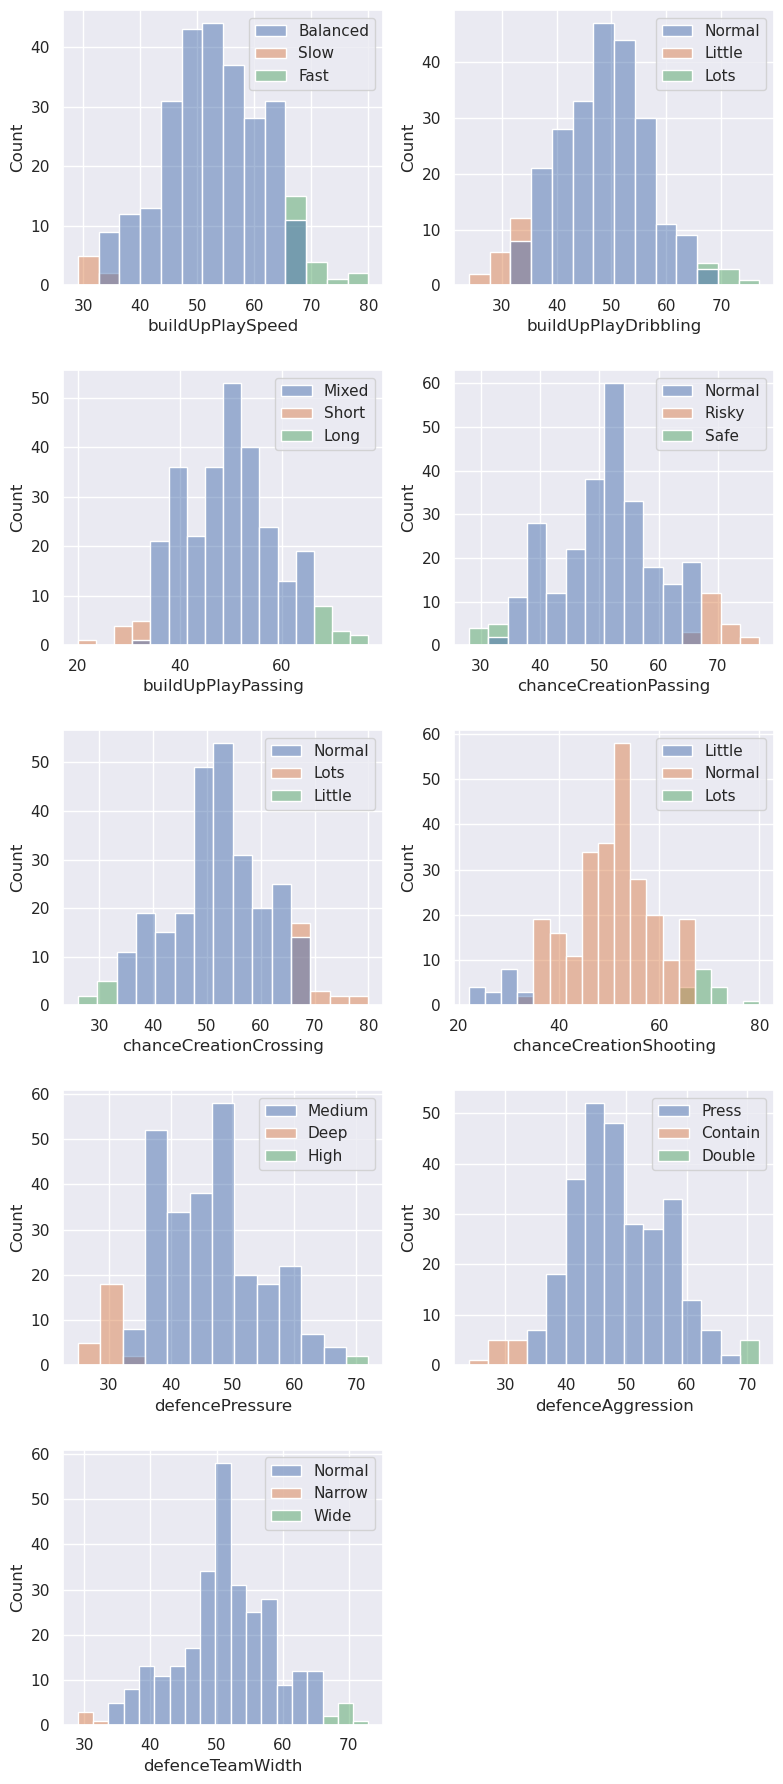

In [28]:
# | label: fig-team_attr
# | fig-cap: Histograms of numeric team attributes. Categories for the same characteristics are also given in the data set, therefore the histograms are split according to those categories.

fig_team_attr, ax_team_attr = plt.subplots(
    5, 2, figsize=(base_fig_width, base_fig_height * 4)
)
ax_team_attr = ax_team_attr.flatten()
for i, attr in enumerate(team_numeric_cols):
    sns.histplot(latest_team_attr, x=attr, hue=attr + "Class", ax=ax_team_attr[i])
    ax_team_attr[i].get_legend().set_title("")

fig_team_attr.delaxes(ax_team_attr[-1])
plt.tight_layout(h_pad=2)
plt.show()

##### Plotting non numeric attributes:

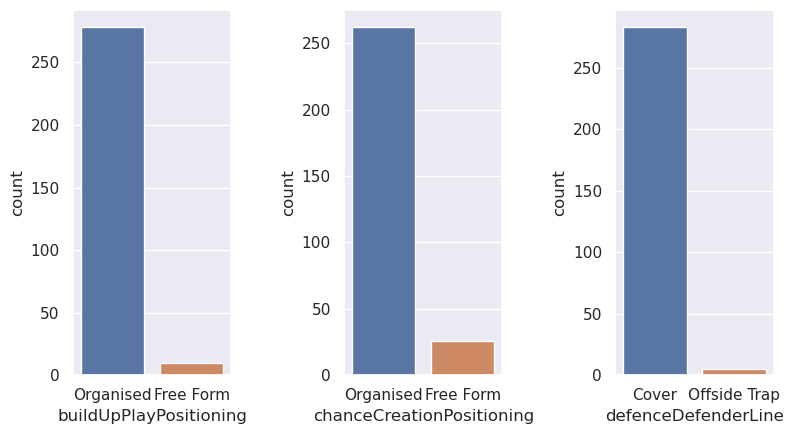

In [29]:
# | label: fig-team_attr_cat
# | fig-cap: The distribution of categorical attributes amongst teams.
team_attr_non_numeric = [
    "buildUpPlayPositioningClass",
    "chanceCreationPositioningClass",
    "defenceDefenderLineClass",
]

fig_team_attr_cat, ax_team_attr_cat = plt.subplots(
    1, 3, figsize=(base_fig_width, base_fig_height)
)
ax_team_attr_cat = ax_team_attr_cat.flatten()

for i, attr in enumerate(team_attr_non_numeric):
    sns.countplot(data=latest_team_attr, x=attr, ax=ax_team_attr_cat[i])
    ax_team_attr_cat[i].set_xlabel(attr[:-5])
plt.tight_layout(w_pad=3)
plt.show()


Team attributes that can be described numerically are given in both numeric and three-category formats as can be seen in @fig-team_attr. Three boolean attributes were also given as seen in @fig-team_attr_cat.

#### Do the numeric team attributes correlate linearly with each other?

In [30]:
disf.get_correlation_pairs(latest_team_attr, 0.3, -0.3).rename(
    {"r-value": "Pearson's r", "feature_pair": "Feature pair"}, axis=1
)

,Pearson's r,Feature pair
0,0.327754,"(buildUpPlaySpeed, chanceCreationPassing)"
2,0.466181,"(defencePressure, defenceAggression)"
3,0.363279,"(defencePressure, defenceTeamWidth)"


Certain defensive attributes seem to have a moderate linear correlation with each other, as well as build up play speed and chance creation passing attributes.

## Feature selection

This section delves into the feature selection process for the final logistic regression model, aimed at predicting whether the home team wins the match. The primary focus of the model lies in achieving high predictive power. As a result, the feature selection heavily relies on the predictive capabilities of different feature sets.

### Starting line-up combinations

Making a copy the match DataFrame with only relevant information:

In [31]:
match_win_df = match_raw[
    [
        "country_id",
        "date",
        "home_team_api_id",
        "away_team_api_id",
        "home_team_goal",
        "away_team_goal",
    ]
]

match_win_df["home_team_win"] = match_win_df.apply(
    lambda x: 1 if x["home_team_goal"] > x["away_team_goal"] else 0, axis=1
)

#### Do combinations influence the match outcome?

##### Adding the combination data:

In [32]:
# Number labels for unique combinations
combo_dict = unique_combos["combo"].to_dict()
combo_dict = {v: k for k, v in combo_dict.items()}

# Adding the combinations from the raw data
match_win_df_combo = pd.merge(
    match_win_df,
    match_raw[["combinations_home", "combinations_away"]],
    left_index=True,
    right_index=True,
)

# Changing the combinations into a single number label
match_win_df_combo[["combinations_home", "combinations_away"]] = match_win_df_combo[
    ["combinations_home", "combinations_away"]
].replace(combo_dict)

# Making a column with the home away combination pairs
match_win_df_combo["combo_home_away"] = match_win_df_combo.apply(
    lambda x: (x["combinations_home"], x["combinations_away"]), axis=1
)
match_win_df_combo["combo_home_away"] = match_win_df_combo["combo_home_away"].apply(
    lambda x: np.nan if np.isnan(x).any() else x
)


##### Chi-squared test with the null hypothesis that home team combination (top 5 combinations only) is not associated to home the home team winning:

In [33]:
comb_h_home_w_con_tab = pd.crosstab(
    match_win_df_combo.loc[
        match_win_df_combo["combinations_home"] <= 5, "home_team_win"
    ],
    match_win_df_combo.loc[
        match_win_df_combo["combinations_home"] <= 5, "combinations_home"
    ],
)
comb_h_home_w_results = stats.chi2_contingency(comb_h_home_w_con_tab)
Markdown(
    f"""Chi-squared statistic: {round(comb_h_home_w_results.statistic,1)}<br>
         p-value: {comb_h_home_w_results.pvalue:.2e}<br>
         The home team combination {'is' if comb_h_home_w_results.pvalue<significance else 'is not'} 
         significantly associated with the home team winning.
         """
)


Chi-squared statistic: 50.8<br>
         p-value: 9.40e-10<br>
         The home team combination is 
         significantly associated with the home team winning.
         

##### Chi-squared test with the null hypothesis that away team combination (top 5 combinations only) is not associated to home the home team winning:

In [34]:
comb_a_home_w_con_tab = pd.crosstab(
    match_win_df_combo.loc[
        match_win_df_combo["combinations_away"] <= 5, "home_team_win"
    ],
    match_win_df_combo.loc[
        match_win_df_combo["combinations_away"] <= 5, "combinations_away"
    ],
)
comb_a_home_w_results = stats.chi2_contingency(comb_a_home_w_con_tab)

Markdown(
    f"""Chi-squared statistic: {round(comb_a_home_w_results.statistic,1)}<br>
         p-value: {comb_a_home_w_results.pvalue:.2e}<br>
         The home team combination 
         {'is' if comb_a_home_w_results.pvalue < significance else 'is not'} 
         significantly associated with the home team winning.
         """
)


Chi-squared statistic: 27.1<br>
         p-value: 5.55e-05<br>
         The home team combination 
         is 
         significantly associated with the home team winning.
         

##### Chi-squared test with the null hypothesis that home-away team combination pair is not associated to home the home team winning:

In [35]:
comb_ha_home_w_con_tab = pd.crosstab(
    match_win_df_combo["combo_home_away"].apply(str),
    match_win_df_combo["home_team_win"],
)
comb_ha_home_w_results = stats.chi2_contingency(comb_ha_home_w_con_tab)

Markdown(
    f"""Chi-squared statistic: {round(comb_ha_home_w_results.statistic,1)}<br>
         p-value: {comb_ha_home_w_results.pvalue:.2e}<br>
         The home-away team combination pair 
         {'is' if comb_ha_home_w_results.pvalue<significance else 'is not'} 
         significantly associated with the home team winning.
         """
)


Chi-squared statistic: 756.2<br>
         p-value: 3.67e-05<br>
         The home-away team combination pair 
         is 
         significantly associated with the home team winning.
         

##### Home team combination-match outcome heatmap:

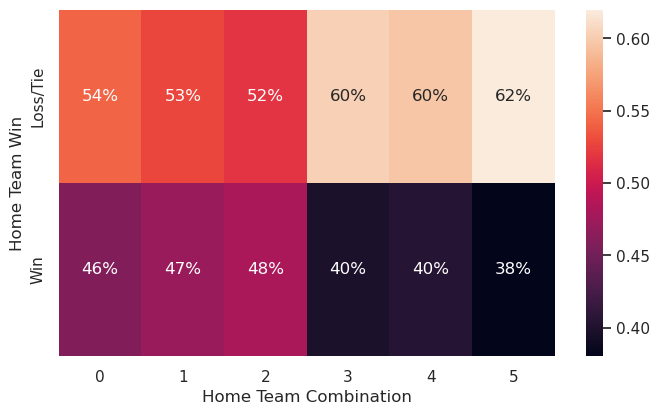

In [36]:
# | label: fig-combo_heatmap
# | fig-cap: Heatmap of six most popular home team starting lineup combinations versus match outcome.

fig_combo_contingency, ax_combo_contingency = plt.subplots(
    figsize=(base_fig_width, base_fig_height)
)
sns.heatmap(
    comb_h_home_w_con_tab.apply(lambda x: x.div(x.sum(), axis=0)),
    fmt=".0%",
    annot=True,
    ax=ax_combo_contingency,
)
disf.axis_titles(
    ax=ax_combo_contingency, xtitle="Home Team Combination", ytitle="Home Team Win"
)

ax_combo_contingency.set_xticklabels(np.arange(0,6))
ax_combo_contingency.set_yticklabels(["Loss/Tie", "Win"])
plt.show()

From the statistical analysis we can say that the starting lineup combinations do influence the match outcome. An example of this is illustrated in @fig-combo_heatmap, where it can be seen that certain combinations such as combination 2 have a higher win percentage than others such as combination 5.

#### Can the combinations be used to predict match outcome?

Due to the categoric nature of the combination data and the number of different categories the random forest model was chosen to test the predictive power of this feature set. The Model is built by using both home team and away team starting lineup combinations.

##### Building the random forest model and making predictions:

In [37]:
match_win_df_combo.dropna(inplace=True)
home_win_target = match_win_df_combo["home_team_win"]
home_win_team_features = match_win_df_combo[["combinations_home", "combinations_away"]]
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    home_win_team_features, home_win_target, test_size=0.33, random_state=1
)

# Create and fit the logistic regression model
logit_model = RandomForestClassifier()
result = logit_model.fit(X_train, y_train)

# Predict using the trained model
predictions = result.predict(X_test)

              precision    recall  f1-score   support

           0       0.55      0.81      0.66      4360
           1       0.48      0.21      0.29      3607

    accuracy                           0.54      7967
   macro avg       0.52      0.51      0.47      7967
weighted avg       0.52      0.54      0.49      7967



##### Classification report:

In [ ]:
print(classification_report(y_test, predictions.round()))

##### Outcome skew in the test set:

In [41]:
y_test.value_counts(normalize=True).to_frame(name="Fraction")

,Fraction
0,0.547257
1,0.452743


##### Receiver operating characteristic curve:

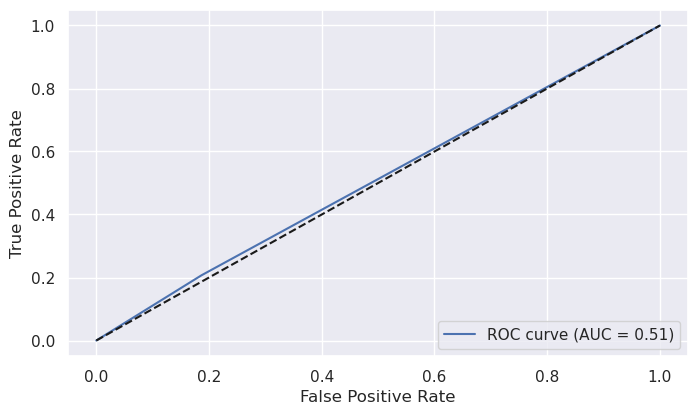

In [42]:
# | label: fig-combo_roc
# | fig-cap: Receiver operating characteristic curve of the home-win predictions made by the random forest model trained on team starting lineup combinations.

fpr, tpr, thresholds = roc_curve(y_test, predictions.round())
auc_score = roc_auc_score(y_test, predictions.round())

fig_combo_roc, ax_combo_roc = plt.subplots(figsize=(base_fig_width, base_fig_height))
ax_combo_roc.plot(fpr, tpr, label="ROC curve (AUC = %0.2f)" % auc_score)
ax_combo_roc.plot([0, 1], [0, 1], "k--")  # Random guessing line
ax_combo_roc.set_xlabel("False Positive Rate")
ax_combo_roc.set_ylabel("True Positive Rate")
ax_combo_roc.legend(loc="lower right")
plt.show()

The random forest model based on the home team and away team starting line-up combinations predicted the game outcome with 54% accuracy. This value does not be the underlying outcome data skew and barely beats random guessing as seen from the ROC curve (@fig_combo_roc) therefore these features are not included in the final model.

### Team Attributes

#### Preparing the features

In the dataset, team attributes have undergone multiple updates over time, likely derived from the respective teams' performances in various matches, possibly even including the matches contained within this dataset. Consequently, we must exercise caution not to incorporate attributes updated after each match occurrence, as doing so could introduce match outcome leakage into our feature set, which can significantly bias the model and compromise its ability to generalize to new, unseen data. To ensure the integrity and validity of our predictive model, we must strictly adhere to using only those team attributes that were available up until the time of each match without incorporating any post-match updates.

##### Importing team attributes into a dataframe:

In [44]:
team_attr_raw = con.query(
    """--sql
SELECT *
FROM Team_attributes
"""
).to_df()

team_attr_raw["date"] = pd.to_datetime(team_attr_raw["date"])
team_attr_raw[team_numeric_cols] = team_attr_raw[team_numeric_cols].apply(pd.to_numeric)

##### Creating Team class objects for each team:

In [45]:
unique_team_ids = [
    i[0]
    for i in con.query(
        """--sql
SELECT DISTINCT team_api_id
FROM Team_attributes
"""
    ).fetchall()
]
teams = {}

for team in unique_team_ids:
    teams[team] = Team(team)
    teams[team].get_data(team_attr_raw)

##### Removing matches with teams that have no attributes:

In [46]:
match_win_df_team = match_win_df[
    match_win_df.index.isin(match_win_df_combo.index)
]  # not using rows with missing combination data
match_win_df_team = match_win_df[
    ~match_win_df["away_team_api_id"].isin(
        set(unique_team_ids).symmetric_difference(
            match_win_df["away_team_api_id"].unique()
        )
    )
]

match_win_df_team = match_win_df_team[
    ~match_win_df_team["home_team_api_id"].isin(
        set(unique_team_ids).symmetric_difference(
            match_win_df_team["home_team_api_id"].unique()
        )
    )
]


##### Getting the latest team attributes by match date using the Team class:

In [47]:
team_attributes_home = {}
for index in match_win_df_team.index:
    team_attributes_home[index] = teams[
        match_win_df_team.at[index, "home_team_api_id"]
    ].get_latest_entry(match_win_df_team.loc[index, "date"], team_numeric_cols)

team_attributes_away = {}
for index in match_win_df_team.index:
    team_attributes_away[index] = teams[
        match_win_df_team.at[index, "away_team_api_id"]
    ].get_latest_entry(match_win_df_team.loc[index, "date"], team_numeric_cols)

match_win_df_team = match_win_df_team.join(
    pd.concat(
        list(team_attributes_home.values()), keys=team_attributes_home.keys()
    ).droplevel(1),
    rsuffix="_home",
)

match_win_df_team = match_win_df_team.join(
    pd.concat(
        list(team_attributes_away.values()), keys=team_attributes_away.keys()
    ).droplevel(1),
    rsuffix="_away",
)


##### Dropping matches where teams do not have date relevant attributes:

In [48]:
match_win_df_team.dropna(inplace=True)

##### Number of matches left:

In [49]:
len(match_win_df_team)

5562

A custom class object called "Team" has been developed, wherein a new instance of the Team class is created for each team in the dataset. This class effectively stores all attribute entries associated with a specific team. Additionally, the class includes a method that, given a specific date and a list of columns, enables retrieval of the latest features that were entered before the specified date.

Using this Team class, relevant date-specific attributes for both the home and away teams were incorporated for each match in the dataset. However, Only five and a half thousand matches out of the total dataset had date-relevant team attributes.

#### Logistic regression with all home and away team attributes

##### Model training and prediction:

In [47]:
cols_to_drop = [
    "date",
    "country_id",
    "home_team_api_id",
    "away_team_api_id",
    "home_team_goal",
    "away_team_goal",
    "home_team_win",
]

home_win_target_team = match_win_df_team["home_team_win"]
home_win_team_features = match_win_df_team.drop(columns=cols_to_drop)

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    home_win_team_features, home_win_target_team, test_size=0.33, random_state=1
)

# Scaling the data
team_feat_scaler = StandardScaler()
X_train = team_feat_scaler.fit_transform(X_train)
X_test = team_feat_scaler.fit_transform(X_test)

# Create and fit the logistic regression model
logit_model_team_raw = sm.Logit(y_train, sm.add_constant(X_train))
result_team_raw = logit_model_team_raw.fit()

# Predict using the trained model
predictions_team_raw = result_team_raw.predict(sm.add_constant(X_test))



Optimization terminated successfully.
         Current function value: 0.670147
         Iterations 4
              precision    recall  f1-score   support

           0       0.59      0.78      0.67      1010
           1       0.55      0.33      0.41       826

    accuracy                           0.58      1836
   macro avg       0.57      0.56      0.54      1836
weighted avg       0.57      0.58      0.56      1836



#### Classification report:

In [ ]:
print(classification_report(y_test, predictions_team_raw.round()))

##### Test set outcome skew:

In [48]:
y_test.value_counts(normalize=True).to_frame(name="Fraction")

,Fraction
0,0.550109
1,0.449891


##### Model coefficients:

In [49]:
pd.DataFrame(
    result_team_raw.params[1:].values,
    index=match_win_df_team.drop(columns=cols_to_drop).columns,
).sort_values(0)


,0
buildUpPlayPassing,-0.119939
defenceAggression_away,-0.117195
buildUpPlaySpeed,-0.075989
defenceTeamWidth,-0.074180
chanceCreationCrossing_away,-0.068292
defencePressure_away,-0.067938
chanceCreationShooting_away,-0.044613
defenceTeamWidth_away,-0.032423
buildUpPlayDribbling_away,-0.010299
buildUpPlayDribbling,-0.009318


The logistic regression model using 18 team features was able to predict the game outcome with a 58% accuracy, that only slightly beats the natural skew of the dataset. Further, in order to reduce the number of features the differences of these team attributes between home and away teams will be used.

#### Logistic regression with home-away team attribute differences

##### Training the model and predictions:

In [50]:
home_win_team_features_dif = match_win_df_team.drop(columns=cols_to_drop)
home_win_team_features_dif = (
    home_win_team_features_dif[team_numeric_cols].values
    - home_win_team_features_dif[[col + "_away" for col in team_numeric_cols]].values
)

team_feat_names = [i + "_diff" for i in team_numeric_cols]
home_win_team_features_dif = pd.DataFrame(
    home_win_team_features_dif,
    columns=team_feat_names,
    index=home_win_target_team.index,
)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    home_win_team_features_dif, home_win_target_team, test_size=0.33, random_state=1
)

# Scale the data
team_feat_ratio_scaler = StandardScaler()
X_train = team_feat_ratio_scaler.fit_transform(X_train)
X_test = team_feat_ratio_scaler.fit_transform(X_test)

# Create and fit the logistic regression model
logit_model = sm.Logit(y_train, sm.add_constant(X_train))
result = logit_model.fit()

# Predict using the trained model
predictions = result.predict(sm.add_constant(X_test))

# Print the classification report
print(classification_report(y_test, predictions.round()))


Optimization terminated successfully.
         Current function value: 0.672126
         Iterations 4
              precision    recall  f1-score   support

           0       0.59      0.79      0.68      1010
           1       0.56      0.32      0.41       826

    accuracy                           0.58      1836
   macro avg       0.57      0.56      0.54      1836
weighted avg       0.57      0.58      0.55      1836



##### Model coefficients:

In [51]:
pd.DataFrame(
    result.params[1:].values,
    index=team_feat_names,
).sort_values(0)


,0
buildUpPlayPassing_diff,-0.155055
buildUpPlaySpeed_diff,-0.052334
defenceTeamWidth_diff,-0.027599
buildUpPlayDribbling_diff,0.003255
chanceCreationPassing_diff,0.011143
chanceCreationShooting_diff,0.068049
defencePressure_diff,0.149047
defenceAggression_diff,0.152408
chanceCreationCrossing_diff,0.153614


#### Dimensionality reduction with principal component analysis

In order to reduce the number of team attributes required for match outcome prediction principal component analysis will be implemented.

##### Scree plot:

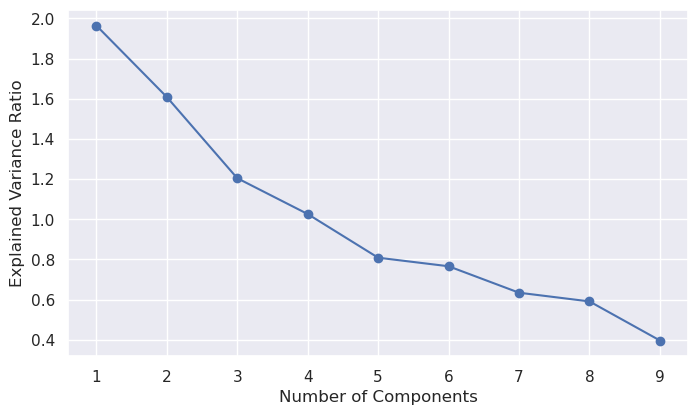

In [52]:
# Perform PCA with maximum number of components
pca_team = PCA(n_components=9)
pca_team.fit(X_train)

fig_scree, ax_scree = plt.subplots(figsize=(base_fig_width, base_fig_height))

ax_scree.plot(
    np.arange(pca_team.n_components_) + 1, pca_team.explained_variance_, marker="o"
)
ax_scree.set_xlabel("Number of Components")
ax_scree.set_ylabel("Explained Variance Ratio")
plt.show()

There seems to be a leveling off of the variance lost after 5 principal components, therefore for further analysis five principal components will be used.

##### Logistic regression using 5 team attribute principle components:

In [53]:
pca = PCA(n_components=5)
X_team_pca_train = pca.fit_transform(X_train)
X_team_pca_test = pca.fit_transform(X_test)

# Create and fit the logistic regression model
logit_model_team_diff_pc = sm.Logit(y_train, sm.add_constant(X_team_pca_train))
result_team_diff_pc = logit_model_team_diff_pc.fit()

# Predict using the trained model
predictions_team_diff_pc = result_team_diff_pc.predict(sm.add_constant(X_team_pca_test))

# Print the classification report
print(classification_report(y_test, predictions_team_diff_pc.round()))

Optimization terminated successfully.
         Current function value: 0.674551
         Iterations 4
              precision    recall  f1-score   support

           0       0.55      0.79      0.65      1010
           1       0.47      0.22      0.30       826

    accuracy                           0.54      1836
   macro avg       0.51      0.51      0.48      1836
weighted avg       0.51      0.54      0.49      1836



Reducing the number of features into five principal components has reduced the accuracy of the model to 54%. This is less than the skew of the test set, therefore even using a relatively large number of principal components has diminished the prediction capabilities to where the model has zero value. Due to this reason PCA will not be used in further analysis, and all 9 attribute differences will be used in the final model.

### Player Attributes

Getting the date relevant attributes of each match player using the MatchPlayer class Player subclass and their functions:

In [54]:
# # only using rows with team attributes
# match_win_df_player = match_win_df.copy()[
#     match_win_df.index.isin(match_win_df_team.index)
# ]

# # Creating MatchPlayers objects for each match
# match_players_series = {}
# for i in match_win_df_player.index:
#     match_players_series[i] = MatchPlayers()
# match_players_series = pd.Series(match_players_series, name="match_players")
# match_win_df_player = match_win_df_player.join(match_players_series)

# # Using the MatchPlayers methods and the player subclass and it's methods to store date
# # player attribute data for each match
# for index, row in match_raw[match_raw.index.isin(match_win_df_player.index)].iterrows():
#     match_win_df_player.at[index, "match_players"].get_data(row)
#     match_win_df_player.at[index, "match_players"].get_player_positions()
#     match_win_df_player.at[index, "match_players"].get_player_ids()
#     match_win_df_player.at[index, "match_players"].home_players[
#         "goaly"
#     ].get_player_attributes(player_attr_raw, row["date"])
#     match_win_df_player.at[index, "match_players"].away_players[
#         "goaly"
#     ].get_player_attributes(player_attr_raw, row["date"])
#     for player in match_win_df_player.at[index, "match_players"].home_players[
#         "players"
#     ]:
#         player.get_player_attributes(player_attr_raw, row["date"])
#     for player in match_win_df_player.at[index, "match_players"].away_players[
#         "players"
#     ]:
#         player.get_player_attributes(player_attr_raw, row["date"])


In [55]:
import pickle

# with open('match_win_df_player.pkl', 'wb') as file:
#     pickle.dump(match_win_df_player, file)

with open("match_win_df_player.pkl", "rb") as file:
    match_win_df_player = pickle.load(file)

#### Logistic regression using all attributes

##### Exporting all player attributes:

In [56]:
# Export all player attributes for each mach in to a dictionary
player_att_dict = {}
for i in match_win_df_player.index:
    player_att_dict[i] = match_win_df_player.at[
        i, "match_players"
    ].export_player_attributes(player_attr_numeric, how="all")

# Merging with the match dataframe
match_win_players = pd.DataFrame.from_dict(player_att_dict, orient="index").join(
    match_win_df["home_team_win"]
)

# Dropping rows with missing values
match_win_players.dropna(inplace=True)

# In some cases missing attributes were returned as empty dictionaries, dropping these rows
match_win_players = match_win_players[
    match_win_players.apply(
        lambda x: False if dict in [type(i) for i in x.values] else True, axis=1
    )
]

##### Logistic Regression with all player attributes:

In [57]:
home_win_target_player = match_win_players["home_team_win"]
home_win_features_player = match_win_players.drop(columns="home_team_win")

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    home_win_features_player, home_win_target_player, test_size=0.33, random_state=1
)

# Scaling the data
player_feat_scaler = StandardScaler()
X_train = player_feat_scaler.fit_transform(X_train)
X_test = player_feat_scaler.fit_transform(X_test)

# Create and fit the logistic regression model
logit_model_player_all = sm.Logit(y_train, sm.add_constant(X_train))
result_player_all = logit_model_player_all.fit_regularized(
    method="l1_cvxopt_cp", alpha=0.2, disp=0
)

# Predict using the trained model
predictions_player_all = result_player_all.predict(sm.add_constant(X_test))

# Print the predicted probabilities
print(classification_report(y_test, predictions_player_all.round()))

              precision    recall  f1-score   support

           0       0.63      0.62      0.62       933
           1       0.52      0.53      0.53       736

    accuracy                           0.58      1669
   macro avg       0.57      0.57      0.57      1669
weighted avg       0.58      0.58      0.58      1669



##### What is the test data set skew?

In [58]:
y_test.value_counts(normalize=True).to_frame("Fraction")

,Fraction
0,0.559017
1,0.440983


##### Coefficients and their p-values:

In [59]:
# Displaying the coefficients and their p-values
params_player_all = result_player_all.params[1:].to_frame(name="Coefficient")
params_player_all["p-value"] = result_player_all.pvalues[1:].values
params_player_all.index = home_win_features_player.columns
display(Markdown("Largest positive coefficients:"))
display(params_player_all.sort_values("Coefficient", ascending=False).head())
display(Markdown("Largest negative coefficients:"))
display(params_player_all.sort_values("Coefficient", ascending=False).tail())

Largest positive coefficients:

,Coefficient,p-value
overall_rating_A_6,0.492667,0.007626
marking_A_2,0.447044,0.004872
overall_rating_H_2,0.412170,0.183666
ball_control_A_10,0.379404,0.014108
sliding_tackle_H_gk,0.315451,0.068476


Largest negative coefficients:

,Coefficient,p-value
overall_rating_H_9,-0.452559,0.054490
sliding_tackle_H_5,-0.493653,0.007058
overall_rating_H_10,-0.512273,0.050265
overall_rating_A_2,-0.567206,0.238090
overall_rating_A_gk,-0.889842,0.303472


The model using all player attributes was able to predict the game outcome with a 58% accuracy. This only slightly beats the data skew, yet uses 770 different features. Due to such large number of features in relevance to the number of samples even using lasso regression to penalize large coefficients, some of the coefficients that are largest in magnitudes have p-values above significance level. Therefore to improve the models predictive power and simplicity attempts to reduce the number of features are required.

#### Logistic regression using the differences of player attributes:

The simplest approach to feature reduction is implemented here by utilizing the differences in attributes between home and away players instead of using attributes from all players. This method effectively reduces the number of features by half. Furthermore, as it is difficult to distinguish between non goalkeeper players instead of separate attribute differences, the average of all non-goalkeeper players is used, this further decreases the number of features several times to the final number of 70 from the original 770.

##### Fetching relevant differences of player attributes:

In [60]:
player_att_dict = {}
for i in match_win_df_player.index:
    player_att_dict[i] = match_win_df_player.at[
        i, "match_players"
    ].export_player_attributes(player_attr_numeric, how="avg_diff")

match_win_players = pd.DataFrame.from_dict(player_att_dict, orient="index").join(
    match_win_df["home_team_win"]
)

# Dropping rows with missing values
match_win_players.dropna(inplace=True)

# In some cases missing attributes were returned as empty dictionaries, dropping these rows
match_win_players = match_win_players[
    match_win_players.apply(
        lambda x: False if dict in [type(i) for i in x.values] else True, axis=1
    )
]

##### Logistic regression using player attribute differences

In [61]:
home_win_target_playerdif = match_win_players["home_team_win"]
home_win_features_playerdif = match_win_players.drop(columns="home_team_win")

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    home_win_features_playerdif,
    home_win_target_playerdif,
    test_size=0.33,
    random_state=1,
)

# Scaling the data
player_feat_scaler = StandardScaler()
X_train = player_feat_scaler.fit_transform(X_train)
X_test = player_feat_scaler.fit_transform(X_test)

# Create and fit the logistic regression model
logit_model_player_dif = sm.Logit(y_train, sm.add_constant(X_train))
result_player_dif = logit_model_player_dif.fit_regularized(
    method="l1_cvxopt_cp", alpha=0.1, disp=0
)

# Predict using the trained model
predictions_player_dif = result_player_dif.predict(sm.add_constant(X_test))

# Print the predicted probabilities
print(classification_report(y_test, predictions_player_dif.round()))


              precision    recall  f1-score   support

           0       0.67      0.75      0.71       933
           1       0.62      0.53      0.58       736

    accuracy                           0.65      1669
   macro avg       0.65      0.64      0.64      1669
weighted avg       0.65      0.65      0.65      1669



##### The most important coefficients and their p-values

In [62]:
params_player_dif = result_player_dif.params[1:].to_frame(name="Coefficient")
params_player_dif["p-value"] = result_player_dif.pvalues[1:].values
params_player_dif.index = home_win_features_playerdif.columns
display(Markdown("Largest positive coefficients:"))
display(params_player_dif.sort_values("Coefficient", ascending=False).head())

Largest positive coefficients:

,Coefficient,p-value
overall_rating_avg_diff_gk,0.656434,0.150866
overall_rating_avg_diff,0.350027,0.046064
vision_avg_diff,0.239988,0.015042
acceleration_avg_diff,0.205494,0.049714
standing_tackle_avg_diff,0.184660,0.082748


Reducing the number of features by calculating the average differences of player attributes has increased the prediction accuracy of the model to 65%. Yet not all of the largest coefficients are significant, which suggest a high uncertainty in their determination and room for model improvement.

RFE

In [63]:
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    home_win_features_playerdif,
    home_win_target_playerdif,
    test_size=0.33,
    random_state=1,
)

# Scaling the data
player_feat_scaler = StandardScaler()
X_train = player_feat_scaler.fit_transform(X_train)
X_test = player_feat_scaler.fit_transform(X_test)

# Create RFE object and perform feature selection
logreg_model_player_pre_rfe = LogisticRegression()
rfe_player = RFECV(estimator=logreg_model_player_pre_rfe)
rfe_player.fit(X_train, y_train)
rfe_selected_columns = home_win_features_playerdif.columns[rfe_player.support_]
# Select the top features based on RFE
X_train_rfe = rfe_player.transform(X_train)
X_test_rfe = rfe_player.transform(X_test)

# Refit the logistic regression model with selected features
logreg_model_rfe = sm.Logit(y_train, sm.add_constant(X_train_rfe))
result_player_rfe = logreg_model_rfe.fit(disp=0)

# Predict using the trained model with selected features
predictions_rfe = result_player_rfe.predict(sm.add_constant(X_test_rfe))

# Print the predicted probabilities
print(classification_report(y_test, predictions_rfe.round()))

              precision    recall  f1-score   support

           0       0.67      0.77      0.71       933
           1       0.64      0.52      0.57       736

    accuracy                           0.66      1669
   macro avg       0.65      0.64      0.64      1669
weighted avg       0.66      0.66      0.65      1669



##### Features selected by RFE and their coefficients:

In [64]:
player_rfe_params = result_player_rfe.params[1:].to_frame(name="Coefficient")
player_rfe_params["p-value"] = result_player_rfe.pvalues[1:].values
player_rfe_params.index = rfe_selected_columns
display(Markdown("Largest positive coefficients:"))
display(player_rfe_params.sort_values("Coefficient", ascending=False).head())

Largest positive coefficients:

,Coefficient,p-value
overall_rating_avg_diff,0.620137,8.780594e-16
vision_avg_diff,0.193314,6.013069e-03
standing_tackle_avg_diff,0.152692,7.746064e-02
sliding_tackle_avg_diff,-0.198702,2.004563e-02


#### Single Feature

In [65]:
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    home_win_features_playerdif["overall_rating_avg_diff"],
    home_win_target_playerdif,
    test_size=0.33,
    random_state=1,
)

# Scaling the data
player_feat_scaler = StandardScaler()
X_train = player_feat_scaler.fit_transform(X_train.values.reshape(-1, 1))
X_test = player_feat_scaler.fit_transform(X_test.values.reshape(-1, 1))

# Fit
logreg_model_overall_rat = sm.Logit(y_train, sm.add_constant(X_train))
result_player_overall_rat = logreg_model_overall_rat.fit(disp=0)

# Predict using the trained model with selected features
predictions_overall_rat = result_player_overall_rat.predict(sm.add_constant(X_test))

# Print the predicted probabilities
print(classification_report(y_test, predictions_overall_rat.round()))


              precision    recall  f1-score   support

           0       0.66      0.76      0.71       933
           1       0.63      0.51      0.56       736

    accuracy                           0.65      1669
   macro avg       0.65      0.64      0.64      1669
weighted avg       0.65      0.65      0.65      1669



##### Model plot:

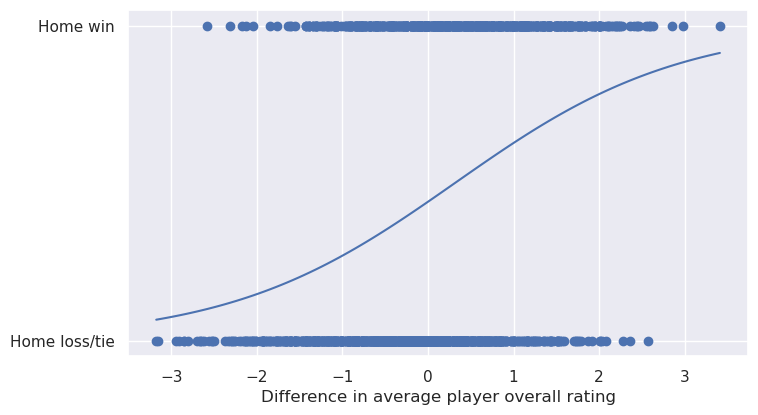

In [66]:
fig_player_log, ax_player_log = plt.subplots(figsize=(base_fig_width, base_fig_height))
x_values = np.linspace(min(X_test), max(X_test), 100)
# Calculate corresponding y-values using logistic function
y_values = 1 / (
    1
    + np.exp(
        -(
            result_player_overall_rat.params[1] * x_values
            + result_player_overall_rat.params[0]
        )
    )
)

ax_player_log.scatter(X_test, y_test)
ax_player_log.plot(x_values, y_values)
disf.axis_titles(ax_player_log, "Difference in average player overall rating")
ax_player_log.set_yticks((0, 1))
ax_player_log.set_yticklabels(("Home loss/tie", "Home win"))
plt.show()

## Game outcome prediction models

### Home win

#### Model Training and predictions

##### Creating a dataframe with all features to be used:

In [67]:
match_win_final_df = match_win_df.merge(
    home_win_features_playerdif[rfe_selected_columns], left_index=True, right_index=True
)

match_win_final_df = match_win_final_df.merge(
    home_win_team_features_dif, left_index=True, right_index=True
)


##### Fitting the model and making predictions:

In [68]:
home_win_final_target = match_win_final_df["home_team_win"]
home_win_final_features = match_win_final_df[
    team_feat_names + rfe_selected_columns.to_list()
]

# Splitting the data into training and test sets
X_train_win, X_test_win, y_train_win, y_test_win = train_test_split(
    home_win_final_features,
    home_win_final_target,
    test_size=0.33,
    random_state=1,
)

# Scaling the data
final_feat_scaler = StandardScaler()
X_train_win = player_feat_scaler.fit_transform(X_train_win)
X_test_win = player_feat_scaler.fit_transform(X_test_win)

# Create and fit the logistic regression model
logit_model_win = sm.Logit(y_train_win, sm.add_constant(X_train_win))
result_win_final = logit_model_win.fit_regularized(
    method="l1_cvxopt_cp", alpha=0.0, disp=0
)

# Predict using the trained model
predictions_win_final = result_win_final.predict(sm.add_constant(X_test_win))

#### Model evaluation:

##### Significant coefficients:

In [69]:
params_win_final = result_win_final.params[1:].to_frame(name="Coefficient")
params_win_final["p-value"] = result_win_final.pvalues[1:].values
params_win_final.index = home_win_final_features.columns

display(Markdown("Significant Coefficients:"))
display(
    params_win_final.sort_values("Coefficient", ascending=False)
    .loc[params_win_final["p-value"] < significance]
    .style.format({"Coefficient": "{:.3f}"})
)


Significant Coefficients:

,Coefficient,p-value
overall_rating_avg_diff,0.612,0.000000
vision_avg_diff,0.177,0.013564
standing_tackle_avg_diff,0.174,0.048862
sliding_tackle_avg_diff,-0.218,0.012162


##### Classification report:

In [70]:
print(classification_report(y_test_win, predictions_win_final.round()))


              precision    recall  f1-score   support

           0       0.67      0.77      0.72       933
           1       0.65      0.52      0.58       736

    accuracy                           0.66      1669
   macro avg       0.66      0.65      0.65      1669
weighted avg       0.66      0.66      0.66      1669



##### Receiver Operating Characteristic Curve:

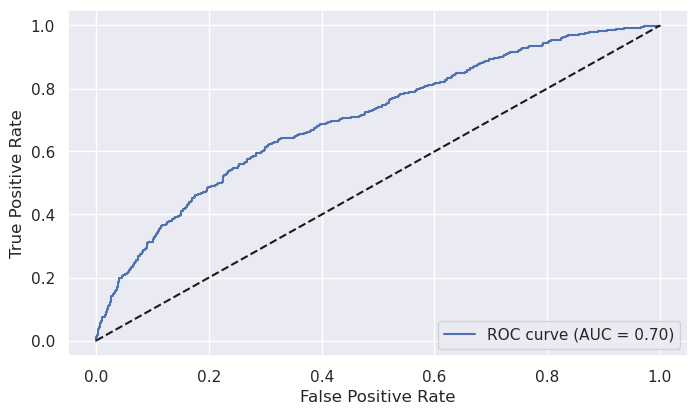

In [71]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test_win, predictions_win_final)
auc_score = roc_auc_score(y_test_win, predictions_win_final)

fig_roc, ax_roc = plt.subplots(figsize=(base_fig_width, base_fig_height))
ax_roc.plot(fpr, tpr, label="ROC curve (AUC = %0.2f)" % auc_score)
ax_roc.plot([0, 1], [0, 1], "k--")  # Random guessing line
ax_roc.set_xlabel("False Positive Rate")
ax_roc.set_ylabel("True Positive Rate")
ax_roc.legend(loc="lower right")
plt.show()

### Away win

#### Modeling and predictions:

##### Preparing the home loss outcome data:

In [72]:
match_win_final_df = match_win_final_df.join(match_raw["outcome"])

match_win_final_df["w_l_t"] = match_win_final_df["outcome"].apply(
    lambda x: "Home Win" if x > 0 else ("Home Loss" if x < 0 else "Tie")
)

match_win_final_df["w_l_t"] = pd.Categorical(
    match_win_final_df["w_l_t"],
    categories=["Home Loss", "Tie", "Home Win"],
    ordered=True,
)

match_win_final_df["home_loss"] = match_win_final_df["w_l_t"].apply(
    lambda x: 1 if x == "Home Loss" else 0
)


##### Model fitting and predictions

In [73]:
home_loss_final_target = match_win_final_df["home_loss"]
home_loss_final_features = match_win_final_df[
    team_feat_names + rfe_selected_columns.to_list()
]

# Splitting the data into training and test sets
X_train_loss, X_test_loss, y_train_loss, y_test_loss = train_test_split(
    home_loss_final_features,
    home_loss_final_target,
    test_size=0.33,
    random_state=1,
)

# Scaling the data
final_feat_scaler = StandardScaler()
X_train_loss = player_feat_scaler.fit_transform(X_train_loss)
X_test_loss = player_feat_scaler.fit_transform(X_test_loss)

# Create and fit the logistic regression model
logit_model_loss = sm.Logit(y_train_loss, sm.add_constant(X_train_loss))
result_loss_final = logit_model_loss.fit_regularized(
    method="l1_cvxopt_cp", alpha=0, disp=0
)

# Predict using the trained model
predictions_loss_final = result_loss_final.predict(sm.add_constant(X_test_loss))

#### Evaluating the model

##### Coefficient importance:

In [74]:
params_loss_final = result_loss_final.params[1:].to_frame(name="Coefficient")
params_loss_final["p-value"] = result_loss_final.pvalues[1:].values
params_loss_final.index = home_loss_final_features.columns

display(Markdown("Significant Coefficients:"))
display(
    params_loss_final.sort_values("Coefficient", ascending=False)
    .loc[params_loss_final["p-value"] < significance]
    .style.format({"Coefficient": "{:.3f}"})
)


Significant Coefficients:

,Coefficient,p-value
sliding_tackle_avg_diff,0.202,0.031679
vision_avg_diff,-0.215,0.005178
overall_rating_avg_diff,-0.636,0.000000


In [75]:
print(classification_report(y_test_loss, predictions_loss_final.round()))


              precision    recall  f1-score   support

           0       0.76      0.92      0.83      1178
           1       0.61      0.28      0.38       491

    accuracy                           0.74      1669
   macro avg       0.68      0.60      0.61      1669
weighted avg       0.71      0.74      0.70      1669



##### Receiver Operating Characteristic Curve:

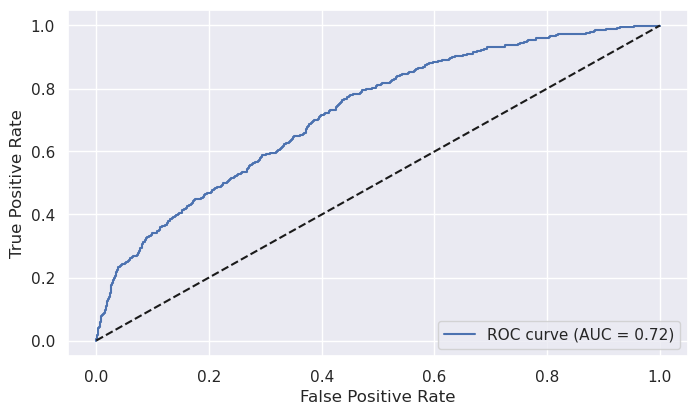

In [76]:
fpr, tpr, thresholds = roc_curve(y_test_loss, predictions_loss_final)
auc_score = roc_auc_score(y_test_loss, predictions_loss_final)

fig_roc_loss, ax_roc_loss = plt.subplots(figsize=(base_fig_width, base_fig_height))
ax_roc_loss.plot(fpr, tpr, label="ROC curve (AUC = %0.2f)" % auc_score)
ax_roc_loss.plot([0, 1], [0, 1], "k--")  # Random guessing line
ax_roc_loss.set_xlabel("False Positive Rate")
ax_roc_loss.set_ylabel("True Positive Rate")
ax_roc_loss.legend(loc="lower right")
plt.show()


### Win-Loss-Tie Classification

#### Ordinal Model

In [77]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

home_win_final_target = match_win_final_df["w_l_t"]
home_win_final_features = match_win_final_df[
    team_feat_names + rfe_selected_columns.to_list()
]

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    home_win_final_features,
    home_win_final_target,
    test_size=0.33,
    random_state=1,
)

# Scaling the data
final_feat_scaler = StandardScaler()
X_train = player_feat_scaler.fit_transform(X_train)
X_test = player_feat_scaler.fit_transform(X_test)

# Create and fit the logistic regression model
ordered_log_model = OrderedModel(y_train, X_train)
result_multi_logit = ordered_log_model.fit(maxiter=10000)

# Predict using the trained model
predictions_wlt = result_multi_logit.predict(X_test)

# Print the predicted probabilities
print(classification_report(np.asarray(y_test.values.codes), predictions_wlt.argmax(1)))

Optimization terminated successfully.
         Current function value: 0.990864
         Iterations: 3516
         Function evaluations: 4596
              precision    recall  f1-score   support

           0       0.48      0.53      0.50       491
           1       0.00      0.00      0.00       442
           2       0.52      0.80      0.63       736

    accuracy                           0.51      1669
   macro avg       0.33      0.44      0.38      1669
weighted avg       0.37      0.51      0.43      1669



#### Custom Classification based on home win and home loss probabilities:

##### Calculating win and loss probabilities for the training set:

In [78]:
predicts_both = pd.DataFrame(
    {
        "win": result_win_final.predict(sm.add_constant(X_train_win)),
        "loss": result_loss_final.predict(sm.add_constant(X_train_loss)),
    }
)


In [79]:
params = Parameters()
params.add("coef_a", value=0.1, min=0.01, max=0.5)
params.add("coef_b", value=0.25, min=0.01, max=0.5)
minner = Minimizer(classifier_train_prob_dif, params, fcn_args=(predicts_both, y_train))
result_final_class = minner.minimize(method="basinhopping")

In [80]:
result_final_class


In [81]:
final_predict = pd.DataFrame(
    {"win": predictions_win_final, "loss": predictions_loss_final}
)

final_predict["guess"] = predicts_both.apply(
    outcome_guess_prob_dif,
    axis=1,
    args=(
        result_final_class.params["coef_a"].value,
        result_final_class.params["coef_b"].value,
    ),
)

print(classification_report(y_test, final_predict["guess"]))

              precision    recall  f1-score   support

   Home Loss       0.32      0.29      0.31       491
    Home Win       0.44      0.67      0.53       736
         Tie       0.29      0.06      0.10       442

    accuracy                           0.40      1669
   macro avg       0.35      0.34      0.31      1669
weighted avg       0.36      0.40      0.35      1669



#### Custom classification based on home-win probabilities

In [82]:
params_prob = Parameters()
params_prob.add("coef_win", value=0.1, min=0.1, max=0.5)
params_prob.add("coef_loss", value=0.25, min=0.1, max=0.5)
minner = Minimizer(
    classifier_train_prob_win, params_prob, fcn_args=(predicts_both["win"], y_train)
)
result_final_class = minner.minimize(method="basinhopping")

In [83]:
final_pred = pd.Series(predictions_win_final).apply(
    outcome_guess_prob_win,
    args=(
        result_final_class.params["coef_win"].value,
        result_final_class.params["coef_loss"].value,
    ),
)

print(classification_report(y_test, final_pred))

              precision    recall  f1-score   support

   Home Loss       0.43      0.75      0.54       491
    Home Win       0.64      0.52      0.58       736
         Tie       0.31      0.14      0.20       442

    accuracy                           0.49      1669
   macro avg       0.46      0.47      0.44      1669
weighted avg       0.49      0.49      0.47      1669



Linear model

In [100]:
player_att_dict = {}
for i in match_win_df_player.index:
    player_att_dict[i] = match_win_df_player.at[
        i, "match_players"
    ].export_player_attributes(player_attr_numeric, how="avg")

goals_df = pd.DataFrame.from_dict(player_att_dict, orient="index")

# Dropping rows with missing values
goals_df.dropna(inplace=True)

# In some cases missing attributes were returned as empty dictionaries, dropping these rows
goals_df = goals_df[
    goals_df.apply(
        lambda x: False if dict in [type(i) for i in x.values] else True, axis=1
    )
]

goals_df = goals_df.join(match_raw["outcome"])
goals_df = goals_df.astype(int)
goals_df = goals_df.drop(
    columns=[
        "overall_rating_H_avg",
        "potential_H_avg",
        "overall_rating_A_avg",
        "potential_A_avg",
        "overall_rating_H_gk",
        "potential_H_gk",
        "overall_rating_A_gk",
        "potential_A_gk",
    ]
)


#### Dropping observationally useless stats

##### Regular player goal keeping stats:

In [101]:
player_gk_stats = [i for i in goals_df.columns if (i[:2] == "gk" and i[-2:] != "gk")]
goals_df = goals_df.drop(columns=player_gk_stats)


##### Irrelevant goal keeper stats based on average values being low:

In [102]:
irrelevant_gk_stats = (
    goals_df[[i for i in goals_df.columns if i[-2:] == "gk"]]
    .mean()[goals_df[[i for i in goals_df.columns if i[-2:] == "gk"]].mean() < 30]
    .index.to_list()
)

goals_df = goals_df.drop(columns=irrelevant_gk_stats)

#### Dropping strong linear correlations

In [103]:
disf.get_correlation_pairs(goals_df, 0.9, -0.9)

,r-value,feature_pair
0,0.928173,"(short_passing_H_avg, long_passing_H_avg)"
1,0.946143,"(short_passing_H_avg, ball_control_H_avg)"
2,0.908599,"(short_passing_H_avg, reactions_H_avg)"
3,0.914209,"(ball_control_H_avg, dribbling_H_avg)"
7,0.910845,"(ball_control_H_avg, reactions_H_avg)"
10,0.938733,"(sliding_tackle_H_avg, standing_tackle_H_avg)"
12,0.903585,"(gk_diving_H_gk, gk_reflexes_H_gk)"
14,0.928766,"(long_passing_A_avg, short_passing_A_avg)"
15,0.942833,"(ball_control_A_avg, short_passing_A_avg)"
16,0.908592,"(reactions_A_avg, short_passing_A_avg)"


In [104]:
# Cluster 1 summarized by ball_control
corr_to_drop = [
    "long_passing_H_avg",
    "short_passing_H_avg",
    "reactions_H_avg",
    "dribbling_H_avg",
    "long_passing_A_avg",
    "short_passing_A_avg",
    "reactions_A_avg",
    "dribbling_A_avg",
]

# Cluster 2 sliding/standing tackles
corr_to_drop.extend(["sliding_tackle_H_avg", "standing_tackle_A_avg"])

# Cluster 3 gk reflexes/diving
corr_to_drop.extend(["gk_diving_H_gk", "gk_diving_A_gk"])

goals_df = goals_df.drop(columns=corr_to_drop)

In [117]:
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    goals_df.drop(columns="outcome"),
    goals_df["outcome"],
    test_size=0.33,
    random_state=1,
)

# Scaling the data
team_feat_scaler = StandardScaler()
X_train = team_feat_scaler.fit_transform(X_train)
X_test = team_feat_scaler.fit_transform(X_test)

from sklearn.linear_model import LinearRegression

lin_reg_pre_rfe = LinearRegression()
lin_rfe = RFECV(lin_reg_pre_rfe, step=1, cv=10)
lin_rfe = lin_rfe.fit(X_train, y_train)

# Create and fit the logistic regression model
goal_model_all = sm.OLS(y_train, sm.add_constant(X_train[:, lin_rfe.support_]))
result_goal_all = goal_model_all.fit()

# Predict using the trained model
predictions_goal_all = result_goal_all.predict(
    sm.add_constant(X_test[:, lin_rfe.support_])
)

In [118]:
params_goal_all = pd.DataFrame(
    {
        "Coefficient": result_goal_all.params[1:].values,
        "p-value": result_goal_all.pvalues[1:].values,
    },
    # index=goals_df.drop(columns="outcome").columns,
    index=goals_df.drop(columns="outcome").columns[lin_rfe.support_],
)

params_goal_all.loc[params_goal_all["p-value"] < significance].sort_values(
    "Coefficient", key=lambda x: abs(x), ascending=False
)

,Coefficient,p-value
ball_control_A_avg,-0.509957,6.474667e-16
ball_control_H_avg,0.486730,1.379674e-13
vision_H_avg,0.194598,2.354334e-03
finishing_H_avg,0.171463,8.903101e-04
stamina_A_avg,-0.156420,4.179071e-05
crossing_A_avg,-0.144600,7.165704e-03


<Axes: ylabel='Count'>

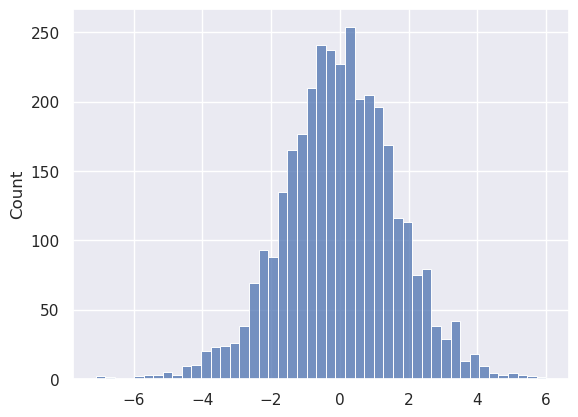

In [108]:
sns.histplot(result_goal_all.resid)


In [109]:
np.sqrt(((y_test - predictions_goal_all) ** 2).sum() / len(y_test))

1.6355887717510031

              precision    recall  f1-score   support

          -6       0.00      0.00      0.00         4
          -5       0.00      0.00      0.00         3
          -4       0.00      0.00      0.00        20
          -3       0.00      0.00      0.00        52
          -2       0.24      0.04      0.07       137
          -1       0.27      0.24      0.26       275
           0       0.30      0.50      0.37       442
           1       0.23      0.37      0.28       322
           2       0.25      0.16      0.19       222
           3       0.20      0.01      0.02       117
           4       0.00      0.00      0.00        52
           5       0.00      0.00      0.00        12
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         2

    accuracy                           0.27      1669
   macro avg       0.10      0.09      0.08      1669
weighted avg       0.23   

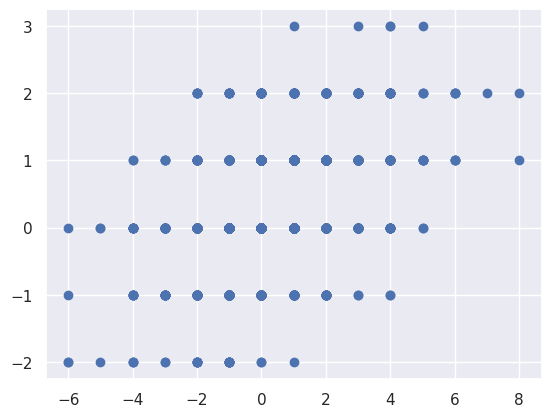

In [110]:
plt.scatter(y_test, predictions_goal_all.round())
print(classification_report(y_test, predictions_goal_all.round()))

<Axes: >

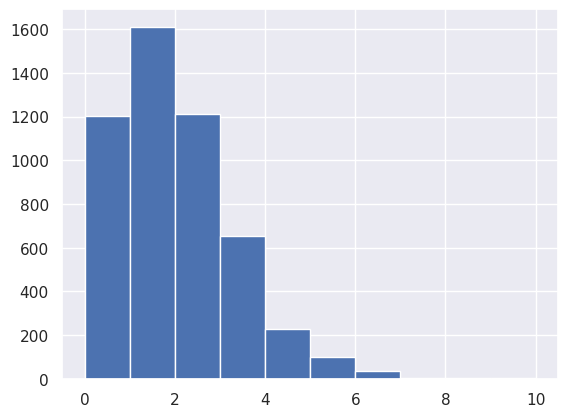

In [99]:
goals_df["home_team_goal"].hist()

In [98]:
result_goal_all.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         home_team_goal   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     46.77
Date:                Thu, 20 Jul 2023   Prob (F-statistic):          1.29e-103
Time:                        10:15:12   Log-Likelihood:                -5463.2
No. Observations:                3386   AIC:                         1.095e+04
Df Residuals:                    3373   BIC:                         1.103e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5162      0.021     72.493      0.000       1.475       1.557
x1             0.0777      0.042      1.855      0.064      -0.004       0.160
x2             0.1159      0.040      2.871      0.004       0.037       0.195
x3             0.0846      0.054      1.576      0.115      -0.021       0.190
x4             0.0764      0.026      2.917      0.004       0.025       0.128
x5             0.1877      0.048      3.891      0.000       0.093       0.282
x6             0.0740      0.022      3.394      0.001       0.031       0.117
x7            -0.1355      0.042     -3.225      0.001      -0.218      -0.053
x8            -0.0603      0.046     -1.322      0.186      -0.150       0.029
x9            -0.1489      0.059     -2.532      0.011      -0.264      -0.034
x10           -0.0961      0.028     -3.379      0.001      -0.152      -0.040
x11            0.1016      0.042      2.435      0.015       0.020       0.183
x12           -0.1177      0.031     -3.822      0.000      -0.178      -0.057
==============================================================================
Omnibus:                      334.058   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              472.935
Skew:                           0.772   Prob(JB):                    2.01e-103
Kurtosis:                       3.984   Cond. No.                         8.19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Summary